# 1- Install Modules:

install ultralytics for YOLOv8

In [2]:
#-- Install-----------------------------------------------------------------------------------------------------
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
#---------------------------------------------------------------------------------------------------------------

Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5519.7/8062.4 GB disk)


# 2- Import Modules:

In [3]:
#-- Import -----------------------------------------------------------------------------------------------------
from ultralytics import YOLO
from ultralytics import FastSAM
from ultralytics.models.fastsam import FastSAMPrompt

import torch

from matplotlib import pyplot as plt
import cv2

import numpy as np
import random
#---------------------------------------------------------------------------------------------------------------

# 3- Initialize Params:

This project was written and executed on kaggle.com.

If you choose to run it in a different environment, please ensure to configure the dir variable according to your specific path.

In [4]:
#-- Initialize --------------------------------------------------------------------------------------------------
images_dir = '/kaggle/input/custome-scale-images/'
#----------------------------------------------------------------------------------------------------------------

# 4- Function "plot_image":
a function to plot image with specific title

In [5]:
#-- Function to Plot an image -----------------------------------------------------------------------------------
def plot_image(image , title):
    plt.axis('off')
    plt.title(title)
    plt.imshow(image)
    plt.show()
#----------------------------------------------------------------------------------------------------------------

# 5- Function "drone_segmentation" :
This function executes an image segmentation task utilizing the fast-SAM model, employing textual cues to isolate objects identified as "drones."

fast-SAM represents a Zero-Shot Image Segmentation model. For further exploration, please refer to:
https://docs.ultralytics.com/models/fast-sam/


In [6]:
#-- Object Segmanetaion Using FASTSAM ---------------------------------------------------------------------------
def drone_segmentation(input_image):
    
    #-- Create a FastSAM model --
    model = FastSAM('FastSAM-x.pt')
    
    #-- Run inference on input_image --
    everything_results = model(input_image,
                               device= 'cpu',
                               retina_masks= True,
                               conf= 0.6,       
                               iou= 0.9,
                               save= True)

    #-- Prepare a Prompt Process object --
    prompt_process = FastSAMPrompt(input_image,
                                   everything_results,
                                   device='cpu')
    
    #-- Text prompt --
    annotations = prompt_process.text_prompt(text='drone')    
    
    return annotations
#----------------------------------------------------------------------------------------------------------------

# 6- Function "create_mask" :
This function generates a mask from the segmented object.

In [7]:
#-- Create a Mask on Segmented Object -------------------------------------------------------------------------------
def create_mask(annotations):
    
    masks = annotations[0].masks.data
    mask = masks[0]       
    mask = mask.int()* 255
    mask = mask.cpu().numpy()
    
    return mask
#--------------------------------------------------------------------------------------------------------------------

# 7- Function "mask_image" :
This function retrieves the generated masked object from the "create_mask" function and applies it to the original image to separate the object from the background.

In [8]:
#-- Mask Input Images -----------------------------------------------------------------------------------------------
def mask_image(input_image, mask):
    
    resized_mask = cv2.resize(mask.astype(float), (input_image.shape[1], input_image.shape[0]))  
    
    mask_3channel = np.zeros_like(input_image)
    mask_3channel[:, :, 0] = resized_mask
    mask_3channel[:, :, 1] = resized_mask
    mask_3channel[:, :, 2] = resized_mask
    
    masked_image = cv2.bitwise_and(input_image, mask_3channel)

    
    mask_3channel = np.zeros_like(input_image)
    mask_3channel[:, :, 0] = resized_mask
    mask_3channel[:, :, 1] = 0
    mask_3channel[:, :, 2] = 0
    
    segmented_image = cv2.bitwise_or(input_image, mask_3channel)    
    
    return masked_image, segmented_image
#--------------------------------------------------------------------------------------------------------------------

# 8- Function "crop_segmented_drone" :
This function crops the segmented object from the initial image

In [9]:
#-- Crope Segmented Object -------------------------------------------------------------------------------------------
def crop_segmented_drone(input_image, masked_image):
    
    #-- Convert masked_image to grayscale for contour detection --
    gray_masked = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    
    #-- Find contours --
    contours, _ = cv2.findContours(gray_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    #-- Select the largest contour (main object) --
    largest_contour = max(contours, key=cv2.contourArea)
    
    #-- Get the bounding rectangle --
    x, y, w, h = cv2.boundingRect(largest_contour)

    #-- Crop the object from the masked image --
    cropped_object = masked_image[y:y+h, x:x+w]
    
    return cropped_object
#---------------------------------------------------------------------------------------------------------------------

# 9- Function "add_drone_to_back" :
This function adds the cropped object to a randomly chosen or specified location on a background image.

In [10]:
#-- Add Segmented Object To Background Image --------------------------------------------------------------------------
def add_drone_to_back(background_image, cropped_object, offset):
    
    height, width, _ = cropped_object.shape 
    back_height, back_width, _ = background_image.shape 
    
    if offset=='random':
        x_offset = random.randint(0, back_width-width)
        y_offset = random.randint(0, back_height-height)
    
    else:
        x_offset, y_offset = offset[0] , offset[1]
    
    #-- Create a Black image as background --
    black_image = np.zeros_like(background_image, dtype=np.uint8)
   
    #-- Overlay the cropped object onto Black image --
    black_image[y_offset:y_offset+height, x_offset:x_offset+width] = cropped_object
    
    #-- Create a mask by to identify non-black pixels --
    mask = cv2.threshold(cv2.cvtColor(black_image, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)[1]

    #-- Blend the two images using the mask --
    result = cv2.addWeighted(black_image, 1, background_image, 1, 0, dtype=cv2.CV_8U)

    #-- Apply the mask to background_image to add color pixels from black_image --
    result = cv2.bitwise_and(result, result, mask=~mask)    
    blended_image = cv2.bitwise_or(result, black_image)
    
    return blended_image,  (x_offset, y_offset)    
#----------------------------------------------------------------------------------------------------------------------

# 10- Function "blend_drone_and_background" :
This function performs the following tasks:

1. Detects and segments the drone object in the input image.
2. Creates a mask from the segmented drone object.
3. Crops the masked drone object from the input image.
4. Resizes the cropped drone object to a specific scale factor.
5. Adds the resized cropped drone object to a random or specific location on the background image.

In [11]:
#-- Crop, Resize, and Add Drone to Background Image -------------------------------------------------------------------
def blend_drone_and_background(drone_image_file , background_image_file, scale_factor, offset, plot_steps=False):
    
    drone_image = cv2.imread(drone_image_file)
    drone_image = cv2.cvtColor(drone_image, cv2.COLOR_BGR2RGB)
    
    background_image = cv2.imread(background_image_file)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    
    annotations = drone_segmentation(drone_image_file)
    mask = create_mask(annotations[0])    
    
    if plot_steps:
        plot_image(mask , 'mask')
    
    resized_mask = cv2.resize(mask.astype(float),
                              (drone_image.shape[1], drone_image.shape[0]))
    masked_img, segmented_image = mask_image(drone_image, resized_mask)
    
    if plot_steps:
        plot_image(segmented_image , 'segmented_image')
        plot_image(masked_img , 'masked_img')
    
    cropped_object = crop_segmented_drone(drone_image, masked_img)
    
    if plot_steps:
        plot_image(cropped_object , 'cropped_object')
    
    resized_cropped_object = cv2.resize(cropped_object, None, fx=scale_factor, fy=scale_factor)    
    
    result_img, offset = add_drone_to_back(background_image,
                                   resized_cropped_object,
                                   offset)
    
    if plot_steps:
        plot_image(result_img , 'result_img')
    
    return result_img, resized_cropped_object, offset    
#----------------------------------------------------------------------------------------------------------------------

# 11- Function "create_bounding_box" :
This function creates the bounding box for the added drone to the background image in YOLOv8 format, which includes:

1. Class ID: Identifying the object class (e.g., 0).
2. Normalized coordinates of the bounding box: 
   - Center coordinates (center_x, center_y)
   - Width (normalized by image width)
   - Height (normalized by image height)

In [12]:
#-- Create Bounding Box for Drone -------------------------------------------------------------------------------------
def create_bounding_box(image_size, object_size, offset, class_lbl):
    
    img_width, img_height = image_size[1], image_size[0]
    width , height = object_size[1], object_size[0]
    x_offset, y_offset = offset[0] , offset[1]   
    
    center_x = (x_offset + width / 2) / img_width
    center_y = (y_offset + height / 2) / img_height
    norm_width = width / img_width
    norm_height = height / img_height 
    
    bounding_box = [class_lbl,
                    center_x,
                    center_y,
                    norm_width,
                    norm_height]
    
    return bounding_box   
#----------------------------------------------------------------------------------------------------------------------

# 12- Function "draw_bounding_box" :
This function draws the created bounding box on the image.

In [13]:
# Function to draw bounding boxes on an image ------------------------------------------------------------------
def draw_bounding_box(image, bbox):    
    class_id, x_center, y_center, width, height = bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]
    x_center, y_center = x_center * image.shape[1], y_center * image.shape[0]
    width, height = width * image.shape[1], height * image.shape[0]
    x, y = int(x_center - width / 2), int(y_center - height / 2)        
    x, y, w, h = int(x), int(y), int(width), int(height)        
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image
#---------------------------------------------------------------------------------------------------------------

# 13- Function "save_bounding_box" :
This function saves the bounding box coordinates in a text file.

In [14]:
#-- Save Bounding box as YOLO format in text file ---------------------------------------------------------------
def save_bounding_box(bbox , file_path):
    
    with open(file_path, 'w') as label_file:    
        label_file.write(f'{bbox[0]} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n')
    
#---------------------------------------------------------------------------------------------------------------

# 14- Function "Custom_Scale_Augmentation" :
This function executes the custom Scale Augmentation module by performing the following steps:

1. Detects, crops, resizes the drone object, and adds it to the background image (blend_drone_and_background).
2. Creates bounding boxes for the added drone on the background (create_bounding_box).
3. Saves the bounding boxes in a text file in YOLOv8 format (save_bounding_box).

In [15]:
#-- Full Function to Scale Augmentation ------------------------------------------------------------------------
def Custom_Scale_Augmentation(drone_img_file, background_img_file, scale_factor,
                             offset = 'random', class_label=0, plot_steps=True,
                             save= True, lbl_file='lbl.txt'):    
   
    result_img , cropped_object_img, offset = blend_drone_and_background(drone_img_file,
                                                                 background_img_file,
                                                                 scale_factor,
                                                                 offset,
                                                                 plot_steps)                                                                 
    
    bbox = create_bounding_box(image_size = result_img.shape,
                               object_size = cropped_object_img.shape,
                               offset = offset,
                               class_lbl = class_label)

    img_with_bbox = draw_bounding_box(result_img.copy(), bbox)
    
    if plot_steps:
        plot_image(img_with_bbox , 'img_with_bbox')
        
    if save:        
        save_bounding_box(bbox, lbl_file)
    
        
    
    #-- Plot --
    drone_image = cv2.imread(drone_img_file)
    drone_image = cv2.cvtColor(drone_image, cv2.COLOR_BGR2RGB)
    
    background_image = cv2.imread(background_img_file)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))    
    axes[0].imshow(drone_image)
    axes[0].set_title('Drone Object')
    axes[0].axis('off')
    
    axes[1].imshow(background_image)
    axes[1].set_title('Background')
    axes[1].axis('off')
    
    axes[2].imshow(img_with_bbox)
    axes[2].set_title('Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()    
#---------------------------------------------------------------------------------------------------------------

# 15- Run:
Execute the module on sample images.

100%|██████████| 138M/138M [00:01<00:00, 72.9MB/s] 



image 1/1 /kaggle/input/custome-scale-images/drone_3.jpg: 704x1024 46 objects, 6114.2ms
Speed: 23.3ms preprocess, 6114.2ms inference, 2096.7ms postprocess per image at shape (1, 3, 704, 1024)
Results saved to runs/segment/predict
requirements: Ultralytics requirement ['git+https://github.com/openai/CLIP.git'] not found, attempting AutoUpdate...


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ash2zcom


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ash2zcom
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 12.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=9b80666cb71a1af7240901d62b9c94d8e5d786f4e0bda96e9a6a88a510ee6153
  Stored in directory: /tmp/pip-ephem-wheel-cache-cm9l50tq/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip

requirements: AutoUpdate success ✅ 19.2s, installed 1 package: ['git+https://github.com/openai/CLIP.git']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 54.6MiB/s]


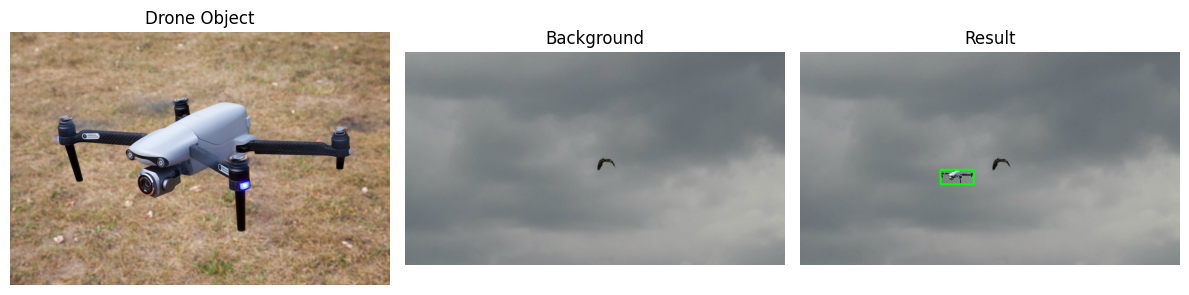

In [17]:
#-- Run ----------------------------------------------------------------------------------------------------------
drone_img = images_dir + 'drone_3.jpg'
background_img = images_dir +'back_2.jpg'

Custom_Scale_Augmentation(drone_img,
                         background_img,
                         scale_factor = 0.03, 
                         class_label=0,
                         plot_steps= False,
                         save= True,
                         lbl_file =  'drone_3.txt')  
#---------------------------------------------------------------------------------------------------------------